*Procedure here is similar to that in 'regression_analysis.ipynb', but with the aim of predicting log_ghg_emissions instead of log_gdp.* 


In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

In [239]:
with open('UN_data_transform.pickle', 'rb') as file:
    UN = pickle.load(file)
    file.close()
UN.head()

,Country,Year,exp_imp,gva_servc,labor_part,food_prod,life_exp,pop_gain,urban,log_gdp,log_pop_density,log_pop,log_gender_ratio,log_energy_prod,log_energy_supp,sqrt_internet,log_edu_prim,sqrt_gva_ag,sqrt_gva_indst,sqrt_unemp,log_tourism,log_health,sqrt_parliam_women,log_cpi,log_mort_child,log_mort_mother,log_num_child,log_pop_migrants,log_pop_unhcr,log_ghg_emissions
0,Afghanistan,2005,-237.675,38.794,64.3,106.6,56.9,4.4,22.7,5.576,3.648,3.222,4.675,0.155,0.000,1.095,5.149,5.937,5.095,2.915,1.593,2.297,5.244,4.264,4.494,6.711,1.974,-1.204,8.759,-0.274
1,Afghanistan,2010,-165.486,49.843,63.3,116.2,60.0,2.8,23.7,6.324,3.786,3.360,4.661,0.515,1.609,2.000,5.211,5.367,4.620,2.793,1.678,2.148,5.225,4.605,4.340,6.370,1.856,-0.916,10.637,0.058
2,Afghanistan,2015,-211.944,54.664,65.3,119.6,62.3,3.2,24.8,6.415,3.945,3.519,4.667,0.707,1.386,2.881,5.235,4.760,4.762,2.983,1.040,2.312,5.263,4.884,4.228,5.981,1.668,0.405,10.648,0.336
3,Albania,2005,-635.065,49.787,57.9,98.0,74.8,-0.3,46.7,7.869,4.722,1.125,4.611,2.762,3.367,2.449,4.347,4.641,5.355,4.183,5.656,1.847,2.530,4.462,3.049,3.401,0.642,0.742,3.397,0.986
4,Albania,2010,-1038.435,50.651,54.3,119.1,75.6,-0.9,52.2,8.308,4.676,1.078,4.612,3.166,3.434,6.708,4.337,4.545,5.356,3.768,6.405,1.611,4.050,4.605,2.821,3.401,0.470,0.588,3.517,1.040


In [241]:
#Train-test split with 2015 data as test
train = UN[(UN.Year == 2005) | (UN.Year == 2010)]
test = UN[UN.Year == 2015]
print(train.shape, test.shape)

(362, 30) (182, 30)


In [242]:
#Make design matrix with all features as predictors except log_ghg_emissions
y, X = patsy.dmatrices('log_ghg_emissions ~ exp_imp + gva_servc + labor_part + \
                       food_prod + life_exp + pop_gain + urban + log_pop_density + \
                       log_pop + log_gender_ratio + log_energy_prod + \
                       sqrt_internet + log_edu_prim + sqrt_gva_ag + sqrt_gva_indst + \
                       sqrt_unemp + log_tourism + log_health + sqrt_parliam_women + \
                       log_cpi + log_mort_child + log_mort_mother + log_num_child + \
                       log_pop_migrants + log_pop_unhcr + log_gdp', 
                       data = UN, return_type = "dataframe")

#Split predictor and response frames according to train-test grouping
X_train, X_test = X[X.index.isin(train.index)], X[X.index.isin(test.index)]
y_train, y_test = y[y.index.isin(train.index)], y[y.index.isin(test.index)]

#Fit base linear regression model with statsmodels
lm_base = sm.OLS(y_train, X_train)
fit_base = lm_base.fit()
fit_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_ghg_emissions   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     55.01
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          1.68e-104
Time:                        14:56:27   Log-Likelihood:                -227.63
No. Observations:                 362   AIC:                             509.3
Df Residuals:                     335   BIC:                             614.3
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4614      2.544      0.181      0.856      -4.543       5.466
exp_imp            -2.286e-06   1.06e-05     -0.215      0.830   -2.32e-05    1.86e-05
gva_servc             -0.0152      0.008     -1.988      0.048      -0.030      -0.000
labor_part             0.0076      0.003      2.502      0.013       0.002       0.014
food_prod             -0.0001      0.002     -0.070      0.944      -0.004       0.004
life_exp              -0.0187      0.008     -2.453      0.015      -0.034      -0.004
pop_gain              -0.0735      0.041     -1.812      0.071      -0.153       0.006
urban                  0.0030      0.002      1.569      0.118      -0.001       0.007
log_pop_density       -0.1239      0.025     -4.991      0.000      -0.173      -0.075
log_pop                0.0270      0.020      1.341      0.181      -0.013       0.067
log_gender_ratio       0.6741      0.440      1.534      0.126      -0.190       1.539
log_energy_prod        0.0306      0.023      1.327      0.185      -0.015       0.076
sqrt_internet         -0.0290      0.027     -1.082      0.280      -0.082       0.024
log_edu_prim          -0.1271      0.061     -2.072      0.039      -0.248      -0.006
sqrt_gva_ag           -0.1609      0.077     -2.086      0.038      -0.313      -0.009
sqrt_gva_indst        -0.1157      0.089     -1.305      0.193      -0.290       0.059
sqrt_unemp            -0.0041      0.033     -0.124      0.901      -0.070       0.062
log_tourism            0.0714      0.027      2.641      0.009       0.018       0.124
log_health            -0.2985      0.078     -3.817      0.000      -0.452      -0.145
sqrt_parliam_women    -0.0260      0.021     -1.251      0.212      -0.067       0.015
log_cpi                0.0961      0.126      0.763      0.446      -0.152       0.344
log_mort_child         0.0860      0.096      0.894      0.372      -0.103       0.275
log_mort_mother       -0.1557      0.055     -2.833      0.005      -0.264      -0.048
log_num_child         -0.2987      0.134     -2.235      0.026      -0.562      -0.036
log_pop_migrants       0.0929      0.028      3.356      0.001       0.038       0.147
log_pop_unhcr         -0.0164      0.010     -1.718      0.087      -0.035       0.002
log_gdp                0.2779      0.072      3.872      0.000       0.137       0.419
==============================================================================
Omnibus:                       31.521   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.366
Skew:                           0.493   Prob(JB):                     2.87e-14
Kurtosis:                       4.778   Cond. No.                     3.43e+05
==============================================================================

In [250]:
#Features deemed insignificant by t-tests of individual coefficients differ from model 
#predicting log_gdp, but some overlap. GHG emissions related to pop_gain, log_health, 
#log_mort_mother, log_pop_migrants, and log_pop_unhcr, but not food_prod, log_pop, and
#log_mort_child. Certainly multicollinearity an issue here. GHG emissions highly related 
#to log_gdp and thus well-predicted by economic wealth of country. 

insig_features = ['exp_imp', 'food_prod', 'log_pop', 'log_energy_prod', 
                  'sqrt_internet', 'sqrt_gva_indst', 'sqrt_unemp', 
                  'sqrt_parliam_women', 'log_cpi', 'log_mort_child']

In [251]:
def diagnostic_plots(model_fit, obs_y):
    """
    Takes a model fit using Statsmodels and the training responses and returns a 2x2 grid of residual plots:
    
    *Residuals vs. Fits
    *Observed vs. Predicted Response
    *Normal QQ-plot of Pearson residuals
    *Pearson residuals vs. leverages
    
    Parameters
    -----------
    model_fit: statsmodels model fit
    obs_y: column dataframe
    
    Returns
    --------
    2x2 grid of residual plots
    """
    
    plt.figure(figsize=(16, 12))

    plt.suptitle('Regression Diagnostic Plots', fontsize = 25, 
             weight = 'bold', family = 'serif', y = 0.95)
    plt.subplots_adjust(hspace = 0.25)
    
    #Residuals vs. Fits
    plt.subplot(2, 2, 1)
    plt.hlines(0, model_fit.predict().min(), model_fit.predict().max(), 
               linestyles = 'dashed', colors = 'lightgrey')
    plt.scatter(model_fit.predict(), model_fit.resid, color = 'lightcoral')
    plt.title("Residuals vs. Fits", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Fits", fontsize = 15, style = 'italic')
    plt.ylabel("Residuals", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    #Observed vs. Predicted Response
    plt.subplot(2, 2, 2)
    plt.plot(np.linspace(model_fit.predict().min(), model_fit.predict().max()), 
         np.linspace(obs_y.min(), obs_y.max()), color = 'lightgrey', linestyle = '--')
    plt.scatter(model_fit.predict(), obs_y, color = 'lightcoral')
    plt.title("Observed vs. Predicted Response", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Predicted Response", fontsize = 15, style = 'italic')
    plt.ylabel("Observed Response", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    #Normal QQ-plot of standardized residuals
    plt.subplot(2, 2, 3)
    stats.probplot(model_fit.resid_pearson, dist = "norm", plot = plt)
    plt.title("Normal Q-Q Plot of Residuals", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Theoretical Quantiles", fontsize = 15, style = 'italic')
    plt.ylabel("Pearson Residuals", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    #standardized residuals vs. leverages
    plt.subplot(2, 2, 4)
    plt.scatter(model_fit.get_influence().hat_matrix_diag, model_fit.resid_pearson, color = 'lightcoral')
    plt.title("Residuals vs. Leverage", fontsize = 18, fontweight = 'bold', family = 'serif')
    plt.xlabel("Leverages", fontsize = 15, style = 'italic')
    plt.ylabel("Pearson Residuals", fontsize = 14, style = 'italic')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    
    plt.show()
    plt.close()

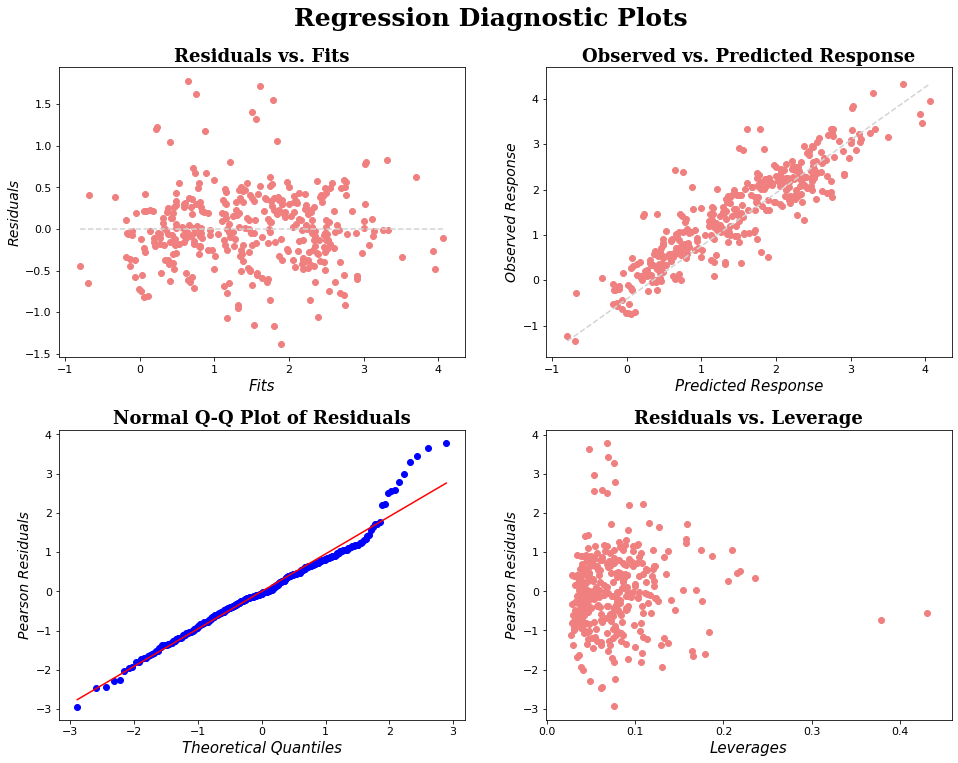

In [252]:
#Normality of residuals more of an issue here - heavy right tail
diagnostic_plots(fit_base, y_train)

In [253]:
#Same high-leverage observations as with log_gdp
influence_base = fit_base.get_influence()
train[influence_base.hat_matrix_diag > 0.3]

,Country,Year,exp_imp,gva_servc,labor_part,food_prod,life_exp,pop_gain,urban,log_gdp,log_pop_density,log_pop,log_gender_ratio,log_energy_prod,log_energy_supp,sqrt_internet,log_edu_prim,sqrt_gva_ag,sqrt_gva_indst,sqrt_unemp,log_tourism,log_health,sqrt_parliam_women,log_cpi,log_mort_child,log_mort_mother,log_num_child,log_pop_migrants,log_pop_unhcr,log_ghg_emissions
462,Qatar,2010,29058.989,32.392,86.7,132.1,77.0,14.4,98.5,11.161,5.032,0.577,5.748,8.336,6.485,8.307,3.909,0.342,8.215,0.707,8.827,0.582,0.000,4.656,2.054,2.773,0.788,4.404,6.568,3.667
600,United Arab Emirates,2010,1373.761,46.687,83.5,108.2,75.9,11.8,84.1,10.464,4.594,2.113,5.677,6.810,5.765,8.246,3.676,0.874,7.249,1.924,6.944,1.355,4.743,4.605,1.932,1.792,0.693,4.483,4.324,3.167


In [254]:
#Still no high-Cook's distance observations
train[influence_base.cooks_distance[0] > 0.05]

,Country,Year,exp_imp,gva_servc,labor_part,food_prod,life_exp,pop_gain,urban,log_gdp,log_pop_density,log_pop,log_gender_ratio,log_energy_prod,log_energy_supp,sqrt_internet,log_edu_prim,sqrt_gva_ag,sqrt_gva_indst,sqrt_unemp,log_tourism,log_health,sqrt_parliam_women,log_cpi,log_mort_child,log_mort_mother,log_num_child,log_pop_migrants,log_pop_unhcr,log_ghg_emissions


In [255]:
#Try dropping the insignificant features
X_train2 = X_train.drop(columns = insig_features)
X_test2 = X_test.drop(columns = insig_features)

In [257]:
#Remaining features significant, but how is multicollinearity?
fit2 = sm.OLS(y_train, X_train2).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_ghg_emissions   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     88.57
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          1.58e-111
Time:                        15:15:52   Log-Likelihood:                -233.26
No. Observations:                 362   AIC:                             500.5
Df Residuals:                     345   BIC:                             566.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5364      1.995     -0.269      0.788      -4.459       3.387
gva_servc           -0.0097      0.003     -3.323      0.001      -0.015      -0.004
labor_part           0.0069      0.003      2.631      0.009       0.002       0.012
life_exp            -0.0237      0.007     -3.422      0.001      -0.037      -0.010
pop_gain            -0.0670      0.038     -1.769      0.078      -0.142       0.007
urban                0.0037      0.002      1.982      0.048    2.81e-05       0.007
log_pop_density     -0.1235      0.021     -5.914      0.000      -0.165      -0.082
log_gender_ratio     0.8608      0.396      2.174      0.030       0.082       1.639
log_edu_prim        -0.1359      0.060     -2.258      0.025      -0.254      -0.018
sqrt_gva_ag         -0.0886      0.036     -2.462      0.014      -0.159      -0.018
log_tourism          0.0528      0.023      2.276      0.023       0.007       0.098
log_health          -0.2903      0.074     -3.915      0.000      -0.436      -0.144
log_mort_mother     -0.1407      0.048     -2.936      0.004      -0.235      -0.046
log_num_child       -0.2773      0.128     -2.161      0.031      -0.530      -0.025
log_pop_migrants     0.0845      0.025      3.400      0.001       0.036       0.133
log_pop_unhcr       -0.0172      0.009     -1.840      0.067      -0.036       0.001
log_gdp              0.2710      0.054      5.059      0.000       0.166       0.376
==============================================================================
Omnibus:                       23.481   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.453
Skew:                           0.388   Prob(JB):                     3.67e-10
Kurtosis:                       4.510   Cond. No.                     1.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [260]:
#log_mort_mother and log_gdp a little concerning
vif = [{X_train2.columns[i]: variance_inflation_factor(np.array(X_train2), i)} for i in range(X_train2.shape[1])]
vif

[{'Intercept': 6460.967174182518},
 {'gva_servc': 2.984366874245773},
 {'labor_part': 1.3155190514210886},
 {'life_exp': 6.74782011378378},
 {'pop_gain': 5.834640973749359},
 {'urban': 2.881718707909335},
 {'log_pop_density': 1.353317755597401},
 {'log_gender_ratio': 3.9793540291716774},
 {'log_edu_prim': 1.9650031077509371},
 {'sqrt_gva_ag': 6.125086158729057},
 {'log_tourism': 4.1717126889791825},
 {'log_health': 1.7945678054391152},
 {'log_mort_mother': 9.74399035155798},
 {'log_num_child': 6.819052206915282},
 {'log_pop_migrants': 2.2571284521966835},
 {'log_pop_unhcr': 1.2723265510724242},
 {'log_gdp': 11.120182986843677}]

In [276]:
#Try dropping log_mort_mother and log_gdp
X_train3 = X_train2.drop(columns = ['log_mort_mother', 'log_gdp'])
X_test3 = X_test2.drop(columns = ['log_mort_mother', 'log_gdp'])

In [277]:
#Now life_exp insignificant
fit3 = sm.OLS(y_train, X_train3).fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_ghg_emissions   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     87.79
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          8.96e-105
Time:                        15:34:58   Log-Likelihood:                -254.50
No. Observations:                 362   AIC:                             539.0
Df Residuals:                     347   BIC:                             597.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2597      1.994     -0.130      0.896      -4.182       3.662
gva_servc           -0.0129      0.003     -4.272      0.000      -0.019      -0.007
labor_part           0.0086      0.003      3.115      0.002       0.003       0.014
life_exp            -0.0007      0.006     -0.121      0.904      -0.012       0.011
pop_gain            -0.0761      0.040     -1.906      0.057      -0.155       0.002
urban                0.0055      0.002      2.827      0.005       0.002       0.009
log_pop_density     -0.1504      0.022     -6.983      0.000      -0.193      -0.108
log_gender_ratio     0.9107      0.417      2.182      0.030       0.090       1.732
log_edu_prim        -0.1900      0.061     -3.127      0.002      -0.309      -0.071
sqrt_gva_ag         -0.2210      0.030     -7.382      0.000      -0.280      -0.162
log_tourism          0.1008      0.023      4.453      0.000       0.056       0.145
log_health          -0.1921      0.077     -2.509      0.013      -0.343      -0.041
log_num_child       -0.3895      0.131     -2.980      0.003      -0.647      -0.132
log_pop_migrants     0.1375      0.025      5.582      0.000       0.089       0.186
log_pop_unhcr       -0.0164      0.010     -1.658      0.098      -0.036       0.003
==============================================================================
Omnibus:                       25.805   Durbin-Watson:                   1.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.958
Skew:                           0.356   Prob(JB):                     2.60e-13
Kurtosis:                       4.826   Cond. No.                     9.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

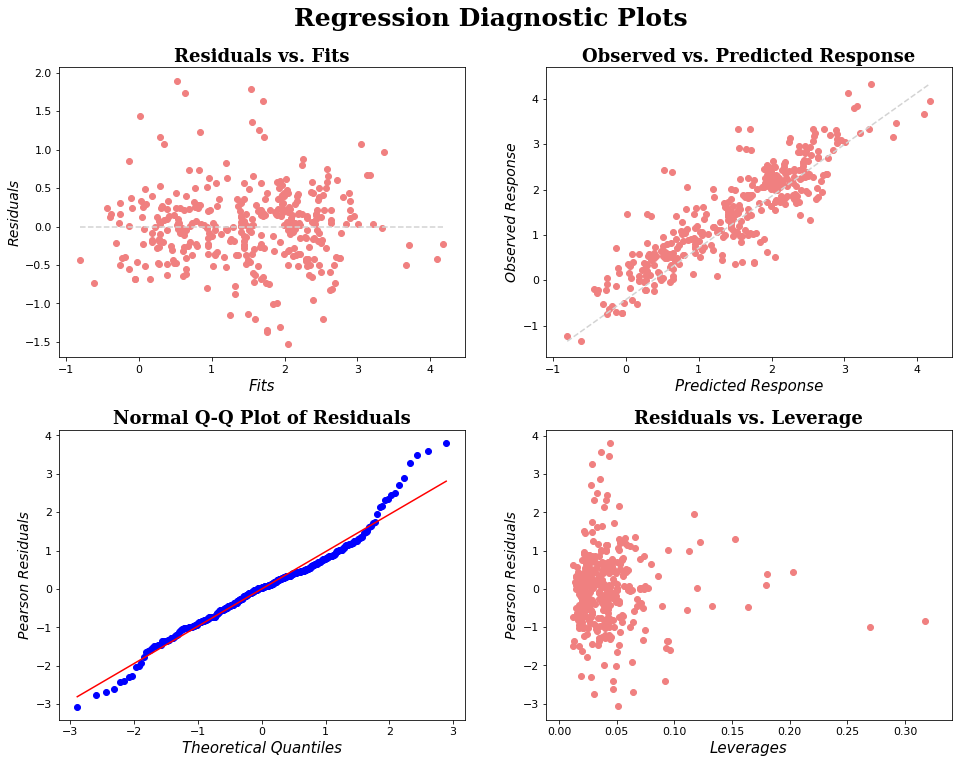

In [278]:
diagnostic_plots(fit3, y_train)

In [279]:
#No more multicollinearity issues
vif2 = [{X_train3.columns[i]: variance_inflation_factor(np.array(X_train3), i)} for i in range(X_train3.shape[1])]
vif2

[{'Intercept': 5775.6713765712775},
 {'gva_servc': 2.8947844817521444},
 {'labor_part': 1.3013552572496283},
 {'life_exp': 4.433786404366844},
 {'pop_gain': 5.800851016827351},
 {'urban': 2.7973332542617917},
 {'log_pop_density': 1.2874532420176918},
 {'log_gender_ratio': 3.954854863496801},
 {'log_edu_prim': 1.7893088714122627},
 {'sqrt_gva_ag': 3.790653706313274},
 {'log_tourism': 3.547411402056087},
 {'log_health': 1.7117560090028507},
 {'log_num_child': 6.32408503587539},
 {'log_pop_migrants': 1.9824531451051466},
 {'log_pop_unhcr': 1.271932007088599}]

In [281]:
#Try dropping life_exp
X_train4 = X_train3.drop(columns = ['life_exp'])
X_test4 = X_test3.drop(columns = ['life_exp'])

#Remaining predictors significant
fit4 = sm.OLS(y_train, X_train4).fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_ghg_emissions   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     94.81
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          9.08e-106
Time:                        15:37:27   Log-Likelihood:                -254.51
No. Observations:                 362   AIC:                             537.0
Df Residuals:                     348   BIC:                             591.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2642      1.991     -0.133      0.895      -4.180       3.651
gva_servc           -0.0130      0.003     -4.320      0.000      -0.019      -0.007
labor_part           0.0087      0.003      3.217      0.001       0.003       0.014
pop_gain            -0.0758      0.040     -1.905      0.058      -0.154       0.002
urban                0.0054      0.002      2.904      0.004       0.002       0.009
log_pop_density     -0.1507      0.021     -7.052      0.000      -0.193      -0.109
log_gender_ratio     0.9011      0.409      2.203      0.028       0.097       1.705
log_edu_prim        -0.1903      0.061     -3.140      0.002      -0.310      -0.071
sqrt_gva_ag         -0.2212      0.030     -7.406      0.000      -0.280      -0.162
log_tourism          0.1001      0.022      4.581      0.000       0.057       0.143
log_health          -0.1920      0.076     -2.511      0.012      -0.342      -0.042
log_num_child       -0.3829      0.119     -3.227      0.001      -0.616      -0.150
log_pop_migrants     0.1378      0.025      5.624      0.000       0.090       0.186
log_pop_unhcr       -0.0163      0.010     -1.656      0.099      -0.036       0.003
==============================================================================
Omnibus:                       26.059   Durbin-Watson:                   1.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.607
Skew:                           0.360   Prob(JB):                     1.88e-13
Kurtosis:                       4.835   Cond. No.                     7.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [282]:
def lr_lasso_ridge_Train_CV(predictors, response, k = 10, random_state = None):
    """
    Takes a dataframe of predictors and a dataframe of responses (training data), 
    finds optimal ridge and LASSO alpha values via cross-validation, conducts k-fold 
    cross-validation with k folds, fits linear regression, ridge, and LASSO models to
    the data, and returns a dataframe with the R^2, RMSE, and MAE values for both the
    training and validation sets of each fold for all three models. 
    
    Parameters
    -----------
    predictors: dataframe 
        predictor features as columns and training data as rows
    response: 1-column dataframe
        training data response values as rows
    k: int 
        number of folds to use for k-fold cross-validation (default is 10)
    random_state: int
        random state value to use for k-fold cross-validation (default is None) 
    
    Returns
    --------
    Dataframe with 18 rows and (k + 1) columns. Rows correspond to training and 
    validation set R^2 scores, RMSE values, and MAE values for linear regression (LR),
    LASSO (L1), and ridge (L2) models. Columns correspond to the kth fold, with the
    final column being the mean value of each row. 
    """
    
    #Find best alpha for Ridge and Lasso using k-fold CV on training set
    alphavec = 10**np.linspace(-2, 2, 200)
    lasso_best_alpha_model = LassoCV(alphas = alphavec, cv = k, random_state = random_state)
    lasso_best_alpha = lasso_best_alpha_model.fit(predictors, response.iloc[:, 0]).alpha_

    ridge_best_alpha_model = RidgeCV(alphas = alphavec, cv = k)
    ridge_best_alpha = ridge_best_alpha_model.fit(predictors, response.iloc[:, 0]).alpha_

    #Setup k-fold CV method
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    
    #Initialize empty vectors for metrics
    lr_r2_tr = []
    lr_r2_te = []
    lr_rmse_tr = []
    lr_rmse_te = []
    lr_mae_tr = []
    lr_mae_te = []
    
    l1_r2_tr = []
    l1_r2_te = []
    l1_rmse_tr = []
    l1_rmse_te = []
    l1_mae_tr = []
    l1_mae_te = []
    
    l2_r2_tr = []
    l2_r2_te = []
    l2_rmse_tr = []
    l2_rmse_te = []
    l2_mae_tr = []
    l2_mae_te = []
    
    for tr, val in kf.split(predictors, response):

        #Split into train and validation sets for each fold
        X_tr, X_val = predictors.iloc[tr], predictors.iloc[val]
        y_tr, y_val = response.iloc[tr], response.iloc[val]

        #Scale using the train set and apply scaling to train and val sets
        scale = StandardScaler().fit(X_tr)
        X_tr = scale.transform(X_tr)
        X_val = scale.transform(X_val)

        #Fit models, using best alphas for ridge and lasso
        lr = LinearRegression().fit(X_tr, y_tr)
        l1 = Lasso(alpha = lasso_best_alpha).fit(X_tr, y_tr)
        l2 = Ridge(alpha = ridge_best_alpha).fit(X_tr, y_tr)

        #Calculate R^2, RMSE, and MAE for each model/fold for train and val splits
        lr_r2_tr.append(r2_score(y_tr, lr.predict(X_tr)))
        lr_r2_te.append(r2_score(y_val, lr.predict(X_val)))
        lr_rmse_tr.append(np.sqrt(mean_squared_error(y_tr, lr.predict(X_tr))))
        lr_rmse_te.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
        lr_mae_tr.append(mean_absolute_error(y_tr, lr.predict(X_tr)))
        lr_mae_te.append(mean_absolute_error(y_val, lr.predict(X_val)))
        
        l1_r2_tr.append(r2_score(y_tr, l1.predict(X_tr)))
        l1_r2_te.append(r2_score(y_val, l1.predict(X_val)))
        l1_rmse_tr.append(np.sqrt(mean_squared_error(y_tr, l1.predict(X_tr))))
        l1_rmse_te.append(np.sqrt(mean_squared_error(y_val, l1.predict(X_val))))
        l1_mae_tr.append(mean_absolute_error(y_tr, l1.predict(X_tr)))
        l1_mae_te.append(mean_absolute_error(y_val, l1.predict(X_val)))
        
        l2_r2_tr.append(r2_score(y_tr, l2.predict(X_tr)))
        l2_r2_te.append(r2_score(y_val, l2.predict(X_val)))
        l2_rmse_tr.append(np.sqrt(mean_squared_error(y_tr, l2.predict(X_tr))))
        l2_rmse_te.append(np.sqrt(mean_squared_error(y_val, l2.predict(X_val))))
        l2_mae_tr.append(mean_absolute_error(y_tr, l2.predict(X_tr)))
        l2_mae_te.append(mean_absolute_error(y_val, l2.predict(X_val)))
        
    #Store metrics in dataframe output
    metrics = pd.DataFrame([lr_r2_tr, lr_r2_te, lr_rmse_tr, lr_rmse_te, lr_mae_tr, lr_mae_te, 
                            l1_r2_tr, l1_r2_te, l1_rmse_tr, l1_rmse_te, l1_mae_tr, l1_mae_te, 
                            l2_r2_tr, l2_r2_te, l2_rmse_tr, l2_rmse_te, l2_mae_tr, l2_mae_te],
                           index = ['lr_r2_tr', 'lr_r2_te', 'lr_rmse_tr', 'lr_rmse_te', 
                                    'lr_mae_tr', 'lr_mae_te', 'l1_r2_tr', 'l1_r2_te', 
                                    'l1_rmse_tr', 'l1_rmse_te', 'l1_mae_tr', 'l1_mae_te', 
                                    'l2_r2_tr', 'l2_r2_te', 'l2_rmse_tr', 'l2_rmse_te', 
                                    'l2_mae_tr', 'l2_mae_te'])
    
    #Calculate means across folds
    metrics['means'] = metrics.apply(np.mean, axis = 1)
    return metrics

In [284]:
#Model performs significantly worse at prediction than log_gdp model, but still decent
#LASSO still offers no improvement over linear regression, and ridge basically identical
lr_lasso_ridge_Train_CV(X_train4, y_train, random_state = 436)

/Users/pilhardt/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,0,1,2,3,4,5,6,7,8,9,means
lr_r2_tr,0.778,0.775,0.769,0.785,0.785,0.792,0.797,0.788,0.765,0.777,0.781
lr_r2_te,0.787,0.798,0.873,0.715,0.723,0.613,0.638,0.688,0.903,0.797,0.754
lr_rmse_tr,0.490,0.492,0.502,0.483,0.482,0.479,0.462,0.481,0.503,0.499,0.487
lr_rmse_te,0.486,0.481,0.357,0.550,0.562,0.586,0.705,0.564,0.334,0.394,0.502
lr_mae_tr,0.359,0.363,0.372,0.359,0.351,0.358,0.345,0.358,0.374,0.372,0.361
lr_mae_te,0.404,0.349,0.281,0.382,0.447,0.425,0.536,0.415,0.269,0.285,0.379
l1_r2_tr,0.776,0.773,0.767,0.783,0.783,0.790,0.795,0.786,0.763,0.775,0.779
l1_r2_te,0.781,0.785,0.869,0.719,0.729,0.607,0.634,0.695,0.896,0.794,0.751
l1_rmse_tr,0.493,0.493,0.504,0.485,0.484,0.481,0.464,0.483,0.506,0.501,0.489
l1_rmse_te,0.492,0.496,0.361,0.547,0.557,0.591,0.709,0.557,0.345,0.397,0.505


In [285]:
def lr_lasso_ridge_Train_Test(pred_train, pred_test, resp_train, resp_test, k = 10, random_state = None):
    """
    Takes 4 dataframes corresponding to the predictor training set, predictor test set, 
    response training set, and response test set, finds optimal ridge and LASSO alpha values 
    via cross-validation on the training set, fits linear regression, ridge, and LASSO models to
    the training data, and returns printed output reporting the R^2, RMSE, and MAE for both the 
    training and test sets for all three models. 
    
    Parameters
    -----------
    pred_train: dataframe 
        predictor features as columns and training data as rows
    pred_test: dataframe 
        predictor features as columns and test data as rows
    resp_train: 1-column dataframe
        training data response values as rows
    resp_test: 1-column dataframe
        test data response values as rows
    k: int 
        number of folds to use for ridge and LASSO cross-validation (default is 10)
    random_state: int
        random state value to use for ridge and LASSO cross-validation (default is None) 
    
    Returns
    --------
    18 lines of printed text output reporting the R^2 score, RMSE value, and MAE value
    for the training and test data of the linear regression (lin reg), LASSO (L1), and 
    ridge (L2) models. 
    """
    
    #Find best alpha for Ridge and Lasso using k-fold CV on training set
    alphavec = 10**np.linspace(-2, 2, 200)
    lasso_best_alpha_model = LassoCV(alphas = alphavec, cv = k, random_state = random_state)
    lasso_best_alpha = lasso_best_alpha_model.fit(pred_train, resp_train.iloc[:, 0]).alpha_

    ridge_best_alpha_model = RidgeCV(alphas = alphavec, cv = k)
    ridge_best_alpha = ridge_best_alpha_model.fit(pred_train, resp_train.iloc[:, 0]).alpha_
    
    #Scale using training set and apply scaling to train and test sets
    scale = StandardScaler().fit(pred_train)
    pred_train_scale = scale.transform(pred_train)
    pred_test_scale = scale.transform(pred_test)

    #Fit models
    lr_model = LinearRegression().fit(pred_train_scale, resp_train)
    l1_model = Lasso(alpha = lasso_best_alpha).fit(pred_train_scale, resp_train)
    l2_model = Ridge(alpha = ridge_best_alpha).fit(pred_train_scale, resp_train)
    
    #Print R^2, RMSE, and MAE values for train and test sets
    print('lin reg train R2: ', r2_score(resp_train, lr_model.predict(pred_train_scale)))
    print('lin reg test R2: ', r2_score(resp_test, lr_model.predict(pred_test_scale)), '\n')
    print('lin reg train RMSE: ', np.sqrt(mean_squared_error(resp_train, lr_model.predict(pred_train_scale))))
    print('lin reg test RMSE: ', np.sqrt(mean_squared_error(resp_test, lr_model.predict(pred_test_scale))), '\n')
    print('lin reg train MAE: ', mean_absolute_error(resp_train, lr_model.predict(pred_train_scale)))
    print('lin reg test MAE: ', mean_absolute_error(resp_test, lr_model.predict(pred_test_scale)), '\n')
    print('lasso train R2: ', r2_score(resp_train, l1_model.predict(pred_train_scale)))
    print('lasso test R2: ', r2_score(resp_test, l1_model.predict(pred_test_scale)), '\n')
    print('lasso train RMSE: ', np.sqrt(mean_squared_error(resp_train, l1_model.predict(pred_train_scale))))
    print('lasso test RMSE: ', np.sqrt(mean_squared_error(resp_test, l1_model.predict(pred_test_scale))), '\n')
    print('lasso train MAE: ', mean_absolute_error(resp_train, l1_model.predict(pred_train_scale)))
    print('lasso test MAE: ', mean_absolute_error(resp_test, l1_model.predict(pred_test_scale)), '\n')
    print('ridge train R2: ', r2_score(resp_train, l2_model.predict(pred_train_scale)))
    print('ridge test R2: ', r2_score(resp_test, l2_model.predict(pred_test_scale)), '\n')
    print('ridge train RMSE: ', np.sqrt(mean_squared_error(resp_train, l2_model.predict(pred_train_scale))))
    print('ridge test RMSE: ', np.sqrt(mean_squared_error(resp_test, l2_model.predict(pred_test_scale))), '\n')
    print('ridge train MAE: ', mean_absolute_error(resp_train, l2_model.predict(pred_train_scale)))
    print('ridge test MAE: ', mean_absolute_error(resp_test, l2_model.predict(pred_test_scale)))

In [286]:
lr_lasso_ridge_Train_Test(X_train4, X_test4, y_train, y_test, random_state = 436)

lin reg train R2:  0.7798294792519366
lin reg test R2:  0.7371043241394692 

lin reg train RMSE:  0.4887627206312163
lin reg test RMSE:  0.5199861991894007 

lin reg train MAE:  0.36142232767822635
lin reg test MAE:  0.39664239886752145 

lasso train R2:  0.7779250994661595
lasso test R2:  0.7426346536661266 

lasso train RMSE:  0.4908719625213437
lasso test RMSE:  0.514487859120684 

lasso train MAE:  0.36388847341585306
lasso test MAE:  0.39346644527050295 

ridge train R2:  0.7797719940262617
ridge test R2:  0.7375457565510394 

ridge train RMSE:  0.48882652300011287
ridge test RMSE:  0.5195494571287159 

ridge train MAE:  0.36180757612862885
ridge test MAE:  0.39642954537266667


/Users/pilhardt/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [287]:
#Re-fit previous models to store and access model output
k = 10
alphavec = 10**np.linspace(-2, 2, 200)
lasso_best_alpha_model = LassoCV(alphas = alphavec, cv = k, random_state = 436)
lasso_best_alpha = lasso_best_alpha_model.fit(X_train4, y_train.iloc[:, 0]).alpha_

ridge_best_alpha_model = RidgeCV(alphas = alphavec, cv = k)
ridge_best_alpha = ridge_best_alpha_model.fit(X_train4, y_train.iloc[:, 0]).alpha_

scale = StandardScaler().fit(X_train4)
X_train_scale = scale.transform(X_train4)
X_test_scale = scale.transform(X_test4)

lr_model = LinearRegression().fit(X_train_scale, y_train)
l1_model = Lasso(alpha = lasso_best_alpha).fit(X_train_scale, y_train)
l2_model = Ridge(alpha = ridge_best_alpha).fit(X_train_scale, y_train)

/Users/pilhardt/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [289]:
#Display LASSO coefficients sorted by absolute value
#No additional features removed
lasso_coef = {X_train4.columns[i]: l1_model.coef_[i] for i in range(X_train4.shape[1])}
sorted(lasso_coef.items(), key = lambda x: np.abs(x[1]))

[('Intercept', 0.0),
 ('log_pop_unhcr', -0.034421787122097),
 ('pop_gain', -0.04454974627290361),
 ('labor_part', 0.07076583576896252),
 ('log_gender_ratio', 0.07112582785246302),
 ('log_health', -0.08310046548547766),
 ('log_edu_prim', -0.10110806056241807),
 ('urban', 0.11398226741519657),
 ('gva_servc', -0.16254869621305446),
 ('log_pop_migrants', 0.18999882092757675),
 ('log_tourism', 0.20286113803415984),
 ('log_pop_density', -0.20629065414726988),
 ('log_num_child', -0.22841085305791056),
 ('sqrt_gva_ag', -0.3739434102348367)]

In [290]:
#Ridge coefficients sorted by absolute value
ridge_coef = {X_train4.columns[i]: l2_model.coef_[0][i] for i in range(X_train4.shape[1])}
sorted(ridge_coef.items(), key = lambda x: np.abs(x[1]))

[('Intercept', 0.0),
 ('log_pop_unhcr', -0.04751206554883973),
 ('log_health', -0.08860390347258325),
 ('labor_part', 0.09165214695948498),
 ('log_gender_ratio', 0.11019404197882407),
 ('log_edu_prim', -0.11066259635175998),
 ('pop_gain', -0.11350962000731783),
 ('urban', 0.1266156450769722),
 ('gva_servc', -0.1828694215161487),
 ('log_num_child', -0.19563881912555792),
 ('log_pop_migrants', 0.2046470936144932),
 ('log_pop_density', -0.20703892456325598),
 ('log_tourism', 0.2163088987979242),
 ('sqrt_gva_ag', -0.3683246117313496)]

In [291]:
def aic(y_obs, y_pred, p):
    """
    Takes two 1-D arrays or 1-column dataframes representing the 
    observed and predicted response values of a linear regression 
    training dataset, as well as the number of model parameters (p), 
    and returns the AIC statistic calculated using the following 
    formula:
    
    (n)ln(RSS) - (n)ln(n) + 2p
    
    Parameters
    ----------
    y_obs: 1-column dataframe or 1-D array
        observed ('true') response values of training dataset
    y_pred: 1-column dataframe or 1-D array
        response values of training dataset predicted using linear 
        regression
    p: int
        number of parameters of linear regression model (including 
        intercept)
    
    Returns
    -------
    AIC statistic (float) of linear regression model.
    """
    n = len(y_obs)
    SSE = np.sum((np.array(y_obs) - np.array(y_pred))**2)
    return (n * np.log(SSE)) - (n * np.log(n)) + (2 * p)

def bic(y_obs, y_pred, p):
    """
    Takes two 1-D arrays or 1-column dataframes representing the 
    observed and predicted response values of a linear regression 
    training dataset, as well as the number of model parameters (p), 
    and returns the BIC statistic calculated using the following 
    formula:
    
    (n)ln(RSS) - (n)ln(n) + (p)ln(n)
    
    Parameters
    ----------
    y_obs: 1-column dataframe or 1-D array
        observed ('true') response values of training dataset
    y_pred: 1-column dataframe or 1-D array
        response values of training dataset predicted using linear 
        regression
    p: int
        number of parameters of linear regression model (including 
        intercept)
    
    Returns
    -------
    BIC statistic (float) of linear regression model.
    """
    n = len(y_obs)
    SSE = np.sum((np.array(y_obs) - np.array(y_pred))**2)
    return (n * np.log(SSE)) - (n * np.log(n)) + (p * np.log(n))

def adj_r2(y_obs, y_pred, p):
    """
    Takes two 1-D arrays or 1-column dataframes representing the 
    observed and predicted response values of a linear regression 
    training dataset, as well as the number of model parameters (p), 
    and returns the Adjusted R^2 score.
    
    Parameters
    ----------
    y_obs: 1-column dataframe or 1-D array
        observed ('true') response values of training dataset
    y_pred: 1-column dataframe or 1-D array
        response values of training dataset predicted using linear 
        regression
    p: int
        number of parameters of linear regression model (including 
        intercept)
    
    Returns
    -------
    Adjusted R^2 score (float) of linear regression model.
    """
    n = len(y_obs)
    SSE = np.sum((np.array(y_obs) - np.array(y_pred))**2)
    SST = np.sum((np.array(y_obs) - float(np.mean(y_obs)))**2)
    return 1 - ((SSE / (n - p - 1)) / (SST / (n - 1)))

In [292]:
def lr_Train_CV(predictors, response, k = 10, random_state = None):
    """
    Takes a dataframe of predictors and a dataframe of responses (training data), 
    conducts k-fold cross-validation with k folds, fits a linear regression model to
    the (unscaled) data, and returns a dataframe with the R^2, Adjusted R^2, RMSE, 
    MAE, AIC, and BIC values for both the training and validation sets of each fold. 
    
    Parameters
    -----------
    predictors: dataframe 
        predictor features as columns and training data as rows
    response: 1-column dataframe
        training data response values as rows
    k: int 
        number of folds to use for k-fold cross-validation (default is 10)
    random_state: int
        random state value to use for k-fold cross-validation (default is None) 
    
    Returns
    --------
    Dataframe with 12 rows and (k + 1) columns. Rows correspond to training and 
    validation set R^2 scores, Adjusted R^2 scores, RMSE values, MAE values, AIC 
    statistics, and BIC statistics for the linear regression model. Columns 
    correspond to the kth fold, with the final column being the mean value of each row. 
    """
    
    #Setup k-fold CV method
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    
    #Initialize empty vectors for metrics
    r2_tr = []
    r2_te = []
    adj_r2_tr = []
    adj_r2_te = []
    rmse_tr = []
    rmse_te = []
    mae_tr = []
    mae_te = []
    aic_tr = []
    aic_te = []
    bic_tr = []
    bic_te = []
    
    for tr, val in kf.split(predictors, response):

        #Split into train and validation sets for each fold
        X_tr, X_val = predictors.iloc[tr], predictors.iloc[val]
        y_tr, y_val = response.iloc[tr], response.iloc[val]
        
        #Fit model
        lr = LinearRegression().fit(X_tr, y_tr)
        
        #Calculate R^2, Adj_R^2, RMSE, MAE, AIC, and BIC for each fold for train and val splits
        r2_tr.append(r2_score(y_tr, lr.predict(X_tr)))
        r2_te.append(r2_score(y_val, lr.predict(X_val)))
        adj_r2_tr.append(adj_r2(y_tr, lr.predict(X_tr), lr.rank_))
        adj_r2_te.append(adj_r2(y_val, lr.predict(X_val), lr.rank_))
        rmse_tr.append(np.sqrt(mean_squared_error(y_tr, lr.predict(X_tr))))
        rmse_te.append(np.sqrt(mean_squared_error(y_val, lr.predict(X_val))))
        mae_tr.append(mean_absolute_error(y_tr, lr.predict(X_tr)))
        mae_te.append(mean_absolute_error(y_val, lr.predict(X_val)))
        aic_tr.append(aic(y_tr, lr.predict(X_tr), lr.rank_))
        aic_te.append(aic(y_val, lr.predict(X_val), lr.rank_))
        bic_tr.append(bic(y_tr, lr.predict(X_tr), lr.rank_))
        bic_te.append(bic(y_val, lr.predict(X_val), lr.rank_))
        
        #Store metrics in dataframe output
        metrics = pd.DataFrame([r2_tr, r2_te, adj_r2_tr, adj_r2_te, rmse_tr, rmse_te, 
                                mae_tr, mae_te, aic_tr, aic_te, bic_tr, bic_te],
                               index = ['r2_train', 'r2_val', 'adj_r2_train', 'adj_r2_val', 
                                        'rmse_train', 'rmse_val', 'mae_train', 'mae_val', 
                                        'aic_train', 'aic_val', 'bic_train', 'bic_val'])
    
    metrics['means'] = metrics.apply(np.mean, axis = 1)
    return metrics

In [294]:
lr_Train_CV(X_train4, y_train, random_state = 436)

,0,1,2,3,4,5,6,7,8,9,means
r2_train,0.778,0.775,0.769,0.785,0.785,0.792,0.797,0.788,0.765,0.777,0.781
r2_val,0.787,0.798,0.873,0.715,0.723,0.613,0.638,0.688,0.903,0.797,0.754
adj_r2_train,0.768,0.765,0.759,0.776,0.776,0.783,0.789,0.779,0.755,0.768,0.772
adj_r2_val,0.666,0.685,0.798,0.546,0.560,0.384,0.424,0.504,0.845,0.678,0.609
rmse_train,0.490,0.492,0.502,0.483,0.482,0.479,0.462,0.481,0.503,0.499,0.487
rmse_val,0.486,0.481,0.357,0.550,0.562,0.586,0.705,0.564,0.334,0.394,0.502
mae_train,0.359,0.363,0.372,0.359,0.351,0.358,0.345,0.358,0.374,0.372,0.361
mae_val,0.404,0.349,0.281,0.382,0.447,0.425,0.536,0.415,0.269,0.285,0.379
aic_train,-437.060,-435.429,-423.729,-448.717,-450.454,-454.015,-477.380,-450.647,-421.519,-426.941,-442.589
aic_val,-27.441,-28.139,-48.215,-16.980,-15.484,-12.431,0.816,-15.277,-52.945,-41.135,-25.723


In [295]:
def lr_Train_Test(pred_train, pred_test, resp_train, resp_test):
    """
    Takes 4 dataframes corresponding to the predictor training set, predictor test set, 
    response training set, and response test set, fits a linear regression model to the 
    training data, and returns printed output reporting the R^2, Adjusted R^2, RMSE, MAE,
    AIC, and BIC values for both the training and test sets. 
    
    Parameters
    -----------
    pred_train: dataframe 
        predictor features as columns and training data as rows
    pred_test: dataframe 
        predictor features as columns and test data as rows
    resp_train: 1-column dataframe
        training data response values as rows
    resp_test: 1-column dataframe
        test data response values as rows 
    
    Returns
    --------
    12 lines of printed text output reporting the R^2 score, Adjusted R^2 score, RMSE 
    value, MAE value, AIC statistic, and BIC statistic for the training and test data of 
    the linear regression model. 
    """
    
    lr2 = LinearRegression().fit(pred_train, resp_train)
    lr2_train_pred = lr2.predict(pred_train)
    lr2_test_pred = lr2.predict(pred_test)
    
    print('Train R2: ', r2_score(resp_train, lr2_train_pred))
    print('Test R2: ', r2_score(resp_test, lr2_test_pred))
    print('Train Adj. R2: ', adj_r2(resp_train, lr2_train_pred, lr2.rank_)) 
    print('Test Adj. R2: ', adj_r2(resp_test, lr2_test_pred, lr2.rank_))
    print('Train RMSE: ', np.sqrt(mean_squared_error(resp_train, lr2_train_pred))) 
    print('Test RMSE: ', np.sqrt(mean_squared_error(resp_test, lr2_test_pred)))
    print('Train MAE: ', mean_absolute_error(resp_train, lr2_train_pred))
    print('Test MAE: ', mean_absolute_error(resp_test, lr2_test_pred))
    print('Train AIC: ', aic(resp_train, lr2_train_pred, lr2.rank_))
    print('Test AIC: ', aic(resp_test, lr2_test_pred, lr2.rank_))
    print('Train BIC: ', bic(resp_train, lr2_train_pred, lr2.rank_))
    print('Test BIC: ', bic(resp_test, lr2_test_pred, lr2.rank_))

In [296]:
lr_Train_Test(X_train4, X_test4, y_train, y_test)

Train R2:  0.7798294792519366
Test R2:  0.7371043241394696
Train Adj. R2:  0.7716047184193939
Test Adj. R2:  0.7167612063645475
Train RMSE:  0.4887627206312163
Test RMSE:  0.5199861991894005
Train MAE:  0.3614223276782266
Test MAE:  0.39664239886752145
Train AIC:  -492.2957741957248
Test AIC:  -212.03889483164335
Train BIC:  -441.7043994419898
Test BIC:  -170.38680789964502
